<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Face_Mask_Detection_using_Convolutional_Neural_Network_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Objectives

At the end of the miniproject, we will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

replace MP2_FaceMask_Dataset/train/with_mask/-110603108-gettyimages-533567012.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Data Downloaded Successfuly!!


### Import Required packages

In [ ]:
import numpy as np
# from PIL import Image
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import optimizers

import matplotlib.image as mpimg
import tensorflow as tf

## Data Loading and preprocessing

### Analyze the shape of images and distribution of classes

In [ ]:
# Load sample images
sample1 = "/content/MP2_FaceMask_Dataset/test/partial_mask/51014_Mask_Mouth_Chin.jpg"

# Scale image features
sample1 = mpimg.imread(sample1)
sample1.shape

(1024, 1024, 3)

### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
PREVIEW_DIR = "/content/MP2_FaceMask_Dataset/preview"
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"
KAGGLE_TEST_DIR = "/content/FaceMask_Kaggle_test"

nb_train_samples = 5029
nb_validation_samples = 1259
batch_size = 16

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('/content/MP2_FaceMask_Dataset/train/without_mask/0.jpg')
x = img_to_array(img)  # this is a Numpy array with shape (3, 160, 160)
print(x.shape)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 160, 160)
print(x.shape)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
# Create the directory
os.makedirs(PREVIEW_DIR, exist_ok=True)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=PREVIEW_DIR, save_prefix='without_mask', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


(160, 160, 3)
(1, 160, 160, 3)


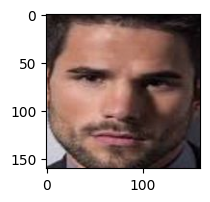

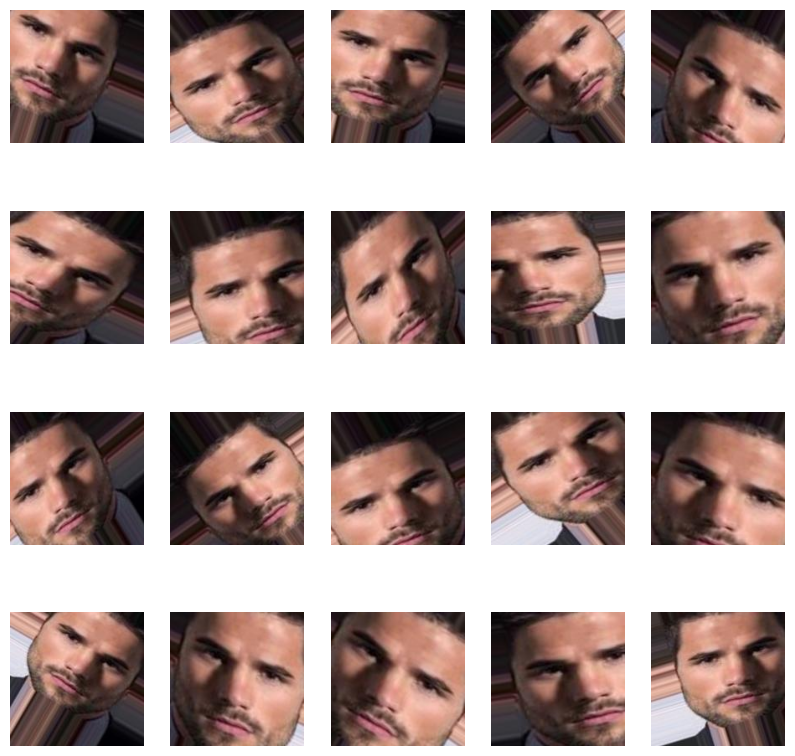

In [ ]:
#Display the original image
# Load the image
img = mpimg.imread('/content/MP2_FaceMask_Dataset/train/without_mask/0.jpg')

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.show()

# Set the directory containing the generated images
image_dir = PREVIEW_DIR

# Get a list of the image filenames
image_files = os.listdir(image_dir)

# Load the first 20 images and display them
fig, axs = plt.subplots(4, 5, figsize=(10, 10))
axs = axs.flatten()
for i in range(20):
    img = mpimg.imread(os.path.join(image_dir, image_files[i]))
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,  # this is the train directory
        class_mode="sparse",  #
        batch_size=batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR, # this is the val directory
        class_mode="sparse",
        batch_size=batch_size)


images, labels = train_generator.next()
images_v, labels_v = validation_generator.next()
print(f"\nShape of train images: {images.shape} \nShape of train labels: {labels.shape}")
print(f"\nShape of vlidation images: {images_v.shape} \nShape of validation labels: {labels_v.shape}")


Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.

Shape of train images: (16, 256, 256, 3) 
Shape of train labels: (16,)

Shape of vlidation images: (16, 256, 256, 3) 
Shape of validation labels: (16,)


### Visualize the sample images of each class using data generator

Hint: plt.subplot

Found 5029 images belonging to 3 classes.


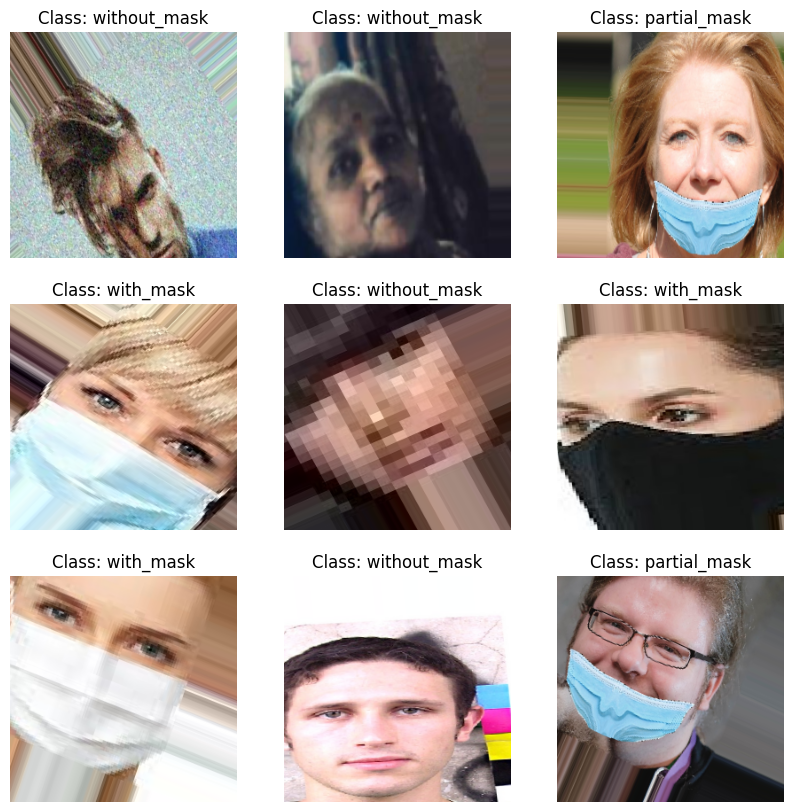

In [ ]:
# Define the target size of the images
target_size = (256, 256)

# Define the batch size
batch_size_local = 9

# Define the classes to be visualized
classes = ['partial_mask', 'with_mask', 'without_mask']

# Generate the data
data = datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=target_size,
    batch_size=batch_size,
    classes=classes,
    shuffle=True
)

# Get the images and labels from the data generator
images, labels = data.next()

# Plot the images
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for img, label, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.set_title(f'Class: {classes[label.argmax()]}')
    ax.axis('off')
plt.show()

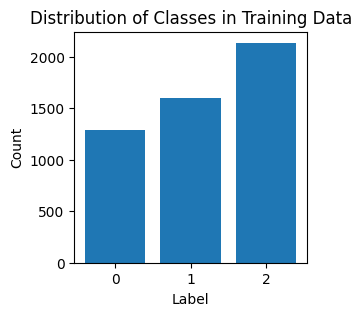

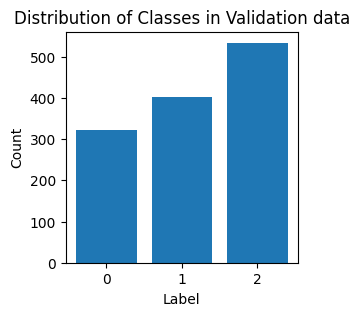

In [ ]:
import collections
# Count the number of occurrences of each label
label_counts = collections.Counter(train_generator.classes)

# Plot the distribution of classes in training data
fig = plt.figure(figsize=(3, 3))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.xticks(np.unique(train_generator.classes))
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

# Count the number of occurrences of each label
label_counts = collections.Counter(validation_generator.classes)

# Plot the distribution of classes in training data
fig = plt.figure(figsize=(3, 3))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.xticks(np.unique(validation_generator.classes))
plt.ylabel('Count')
plt.title('Distribution of Classes in Validation data')
plt.show()

## Build the CNN model using Keras



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=['accuracy'])

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch= nb_train_samples // batch_size,
        epochs=3,
        validation_data=validation_generator,
        validation_steps= nb_validation_samples // batch_size)
model.save_weights('first_try.h5')

<ipython-input-28-357628abed85>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/3
314/314 [==============================] - 103s 306ms/step - loss: 0.3323 - accuracy: 0.2304 - val_loss: 0.1566 - val_accuracy: 0.2532
Epoch 2/3
314/314 [==============================] - 93s 298ms/step - loss: 0.2227 - accuracy: 0.2226 - val_loss: 0.1708 - val_accuracy: 0.2484
Epoch 3/3
314/314 [==============================] - 92s 293ms/step - loss: 0.1656 - accuracy: 0.2422 - val_loss: 0.1351 - val_accuracy: 0.2540


In [ ]:
# Evaluate Model against test data and get the score
score = model.evaluate(validation_generator)

TypeError: ignored

In [ ]:
# Print Metrics
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.14301706850528717
Val accuracy: 0.9579030871391296


## Transfer learning

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224,224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

images, labels = train_generator.next()
images_v, labels_v = validation_generator.next()

images.shape, images_v.shape

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


((16, 224, 224, 3), (16, 224, 224, 3))

In [ ]:
train_generator.image_shape

(224, 224, 3)

In [ ]:
INPUT_SIZE = [224,224]

# build the VGG16 network
model_v = VGG16(input_shape=INPUT_SIZE + [3], weights='imagenet', include_top=False)

for layer in model_v.layers:
    layer.trainable = False

model_v.summary()

flatten = Flatten()(model_v.output)
dense_1 = Dense(units=256, activation='relu')(flatten)
# dense_2 = Dense(units=100, activation='relu')(dense_1)
dense_3 = Dropout(0.5)(dense_1)
dense_output = Dense(units=3, activation='softmax')(dense_3)

model = Model(inputs=model_v.input, outputs=dense_output)
model.summary()

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

r = model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

model.save_weights('bottleneck_fc_model.h5')

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

<ipython-input-21-38e892c48c32>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
315/315 [==============================] - 3452s 11s/step - loss: 0.7496 - accuracy: 0.8417 - val_loss: 0.0989 - val_accuracy: 0.9651
Epoch 2/5
315/315 [==============================] - 3421s 11s/step - loss: 0.1753 - accuracy: 0.9308 - val_loss: 0.0558 - val_accuracy: 0.9801
Epoch 3/5
 24/315 [=>............................] - ETA: 42:00 - loss: 0.1821 - accuracy: 0.9297

KeyboardInterrupt: ignored

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

TensorShape([1, 224, 224, 3])

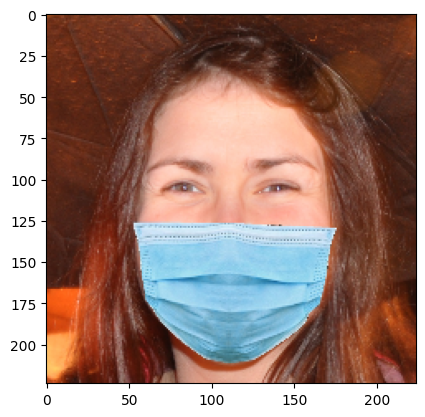

In [ ]:

import tensorflow as tf
tf.experimental.numpy.experimental_enable_numpy_behavior()

img = load_img("/content/FaceMask_Kaggle_test/1.jpg")
# plt.imshow(img)
# Predict the image
img_array = img_to_array(img)
img_array = img_array/ 255.0
img_array_resized = tf.image.resize(img_array, [224,224])
plt.imshow(img_array_resized)

# Preprocess images
# inputs = preprocess_input(img_array_resized * 255)
# inputs.shape
img_array_reshaped = img_array_resized.reshape((1, 224, 224, 3))
img_array_reshaped.shape

In [ ]:
y_pred = model.predict(img_array_reshaped)
print(y_pred)
print(classes[np.argmax(y_pred)])


1/1 [==============================] - 0s 19ms/step
[[9.9167866e-01 8.3213681e-03 9.4623143e-10]]
partial_mask


### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1SsnfllwfdNmsnp_a2K35F12_NJAVgTWz/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [ ]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


In [ ]:
import csv
import datetime

tf.experimental.numpy.experimental_enable_numpy_behavior()

# set the path to the folder containing the images
path = KAGGLE_TEST_DIR

# get the current date and time
now = datetime.datetime.now()

# format the date and time
dt_string = now.strftime("%Y-%m-%d-%H-%M-%S")

# create the file name
file_name = f"results_{dt_string}.csv"

# create a list of the image file names
files = os.listdir(path)

# create a CSV file to store the results
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['img_path', 'label'])

    # iterate over the images
    for file in files:
        # load the image
        img = load_img(os.path.join(path, file))

        # convert to numpy array
        img_array = img_to_array(img)

        # rescale the array
        img_array = img_array / 255.0

        # resize the array
        new_array = tf.image.resize(img_array, [256, 256])

        # prepare the image for prediction
        final_array = new_array.reshape((1,) + new_array.shape)

        # predict the label
        prediction = model.predict(final_array)

        # get the label
        label = classes[np.argmax(prediction)]

        # prepare the csv entry
        img_path = "FaceMask_Kaggle_test" + "/" + file

        # write the result to the CSV file
        writer.writerow([img_path, label])

print('Results saved to results.csv')

1/1 [==============================] - 0s 70ms/step
Results saved to results.csv


### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications